In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

# 一、数据查看
age项缺失大，后续想办法进行补充  
其余三项特征也有缺失值，进行处理

In [2]:
df = pd.read_csv('train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,NaN,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


SibSp 船上是否有兄弟姐妹  
Parch 船上是否有父母子女  
Ticket  票号   
Cabin  船舱  
Embarked  上岸港口

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           890 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [4]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,890.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.180730
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.716425
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.903100
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
# 查看缺失列名称
df.columns[df.isnull().sum()>0]

Index(['Age', 'Fare', 'Cabin', 'Embarked'], dtype='object')

# 二、数据分析

## 2.1PassengerId是否有用

In [6]:
# 判断字段是否是主键字段（唯一）
# 统计PassengerId出现频数并对频数降序处理
df['PassengerId'].value_counts().reset_index().sort_values('PassengerId', ascending=False).head()

,index,PassengerId
0,891,1
598,879,1
587,878,1
588,889,1
589,888,1


In [7]:
# 唯一值字段
del df['PassengerId']
df.columns # 是否删除

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked'],
      dtype='object')

## 2.2Pclass（船舱等级）字段分析

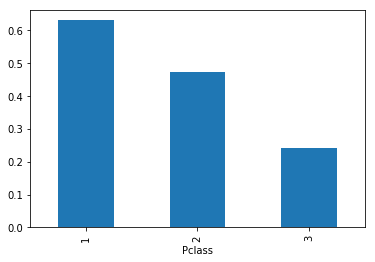

In [8]:
# 查看不同船舱的幸存比
df.groupby('Pclass').mean()['Survived'].plot(kind='bar')

In [9]:
df1 = df.groupby(['Pclass', 'Survived']).count()['Sex'].reset_index()
df1

,Pclass,Survived,Sex
0,1,0,80
1,1,1,136
2,2,0,97
3,2,1,87
4,3,0,372
5,3,1,119


Text(0, 0.5, 'num')

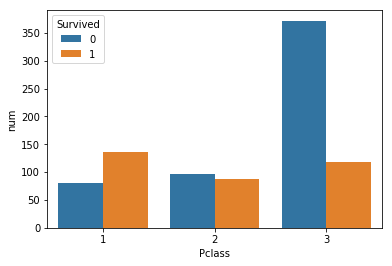

In [10]:
sns.barplot(x='Pclass', y='Sex', hue='Survived', data=df1)# x横坐标， y 纵坐标  hue 分成多个数据   data 分析数据
plt.ylabel('num')

In [11]:
df1 = df.groupby(['Sex', 'Survived']).count()['Pclass'].reset_index()
df1

,Sex,Survived,Pclass
0,female,0,81
1,female,1,233
2,male,0,468
3,male,1,109


Text(0, 0.5, 'num')

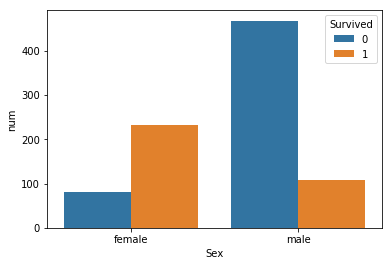

In [12]:
sns.barplot(x='Sex', y='Pclass', hue='Survived', data=df1)
plt.ylabel('num')

## 2.3处理Name字段  
找到name中称呼  
通过称呼分析获救情况

In [13]:
# 查找，存在的位置，找.的位置，分别找到索引位置，进行切片
s= 'Braund, Mr. Owen Harris'
begin = s.index(',')
end = s.index('.')
s[begin+1:end].strip()

'Mr'

In [14]:
# 自定义函数
def fn(s):
    begin = s.index(',') # 查找，位置
    end = s.index('.') # 查找.位置
    return s[begin+1:end].strip() # 切片+去除空格
# 映射处理
df['Name'] = df['Name'].map(fn)
df['Name'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Major             2
Mlle              2
Col               2
the Countess      1
Ms                1
Jonkheer          1
Lady              1
Sir               1
Mme               1
Don               1
Capt              1
Name: Name, dtype: int64

In [15]:
# 称呼已经获取，将相似称呼进行合并
# 找到Name为Sir的数据，将Sir改为Mr
# df.loc[指定行， 指定列] = 修改数据
df.loc[df['Name']=='Sir', 'Name'] = 'Mr'
df.loc[df['Name']=='Mlle', 'Name'] = 'Miss'
# 将Lady和Ms的值转换为Mrs
df.loc[df['Name'].isin(['Lady', 'Ms']), 'Name'] = 'Mrs'
df1 = df['Name'].value_counts().reset_index()
df1

,index,Name
0,Mr,518
1,Miss,184
2,Mrs,127
3,Master,40
4,Dr,7
5,Rev,6
6,Major,2
7,Col,2
8,Jonkheer,1
9,the Countess,1


In [16]:
# 将频数少于3的所有类型合并成一种类别  'rare' 稀有
# 查找 频数小于3所有的称呼
df.loc[df['Name'].isin(df1[df1['Name']<3]['index']), 'Name'] = 'rare'
df['Name'].value_counts()

Mr        518
Miss      184
Mrs       127
Master     40
rare        9
Dr          7
Rev         6
Name: Name, dtype: int64

Text(0, 0.5, 'num')

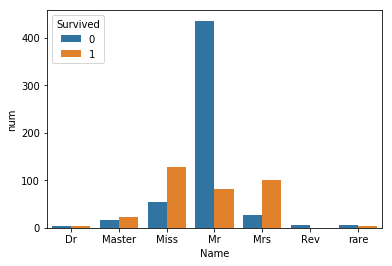

In [17]:
# 分析Name（称呼）和是否幸存之间的关系
# 根据Name和Survived 分组 统计个数
df1 = df.groupby(['Name', 'Survived']).count()['Sex'].reset_index()
# 根据分组的结果使用seaborn来绘制效果
sns.barplot(x='Name', y='Sex', hue='Survived', data=df1)
plt.ylabel('num')

## 2.4 SibSp Parch 联合分析

In [18]:
# Sibsp 同船的兄弟姐妹数量
# Parch 同船的父母、子女数量
print(df['SibSp'].value_counts())
print(df['Parch'].value_counts())

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64
0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64


In [19]:
# 计算当前乘客在船上的家人数量
# Sibsp + Parch + 1
# 新创建一列数据 family 记录船上家人数量
df['family'] = df['SibSp'] + df['Parch'] + 1 # numpy广播机制
df['family'].value_counts()

1     537
2     161
3     102
4      29
6      22
5      15
7      12
11      7
8       6
Name: family, dtype: int64

In [20]:
# 1 single   2,3  small    4+ big
def fn(x):
    if x <2:
        return 'single'
    elif x < 4:
        return 'small'
    else:
        return 'big'
df['family'] = df['family'].map(fn)
df['family'].value_counts()

single    537
small     263
big        91
Name: family, dtype: int64

Text(0, 0.5, 'num')

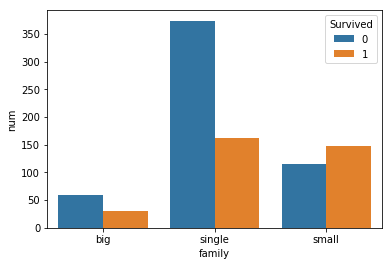

In [21]:
# 可视化分析处理
df1 = df.groupby(['family', 'Survived']).count()['Sex'].reset_index()
sns.barplot(x='family', y='Sex', hue='Survived', data=df1)
plt.ylabel('num')

## 2.5 Ticket字段分析  
票号不重复的内容太多，删除这个字段

In [22]:
df['Ticket'].value_counts()[:5]

347082      7
1601        7
CA. 2343    7
347088      6
CA 2144     6
Name: Ticket, dtype: int64

## 2.6Fare字段

In [23]:
df['Fare'].isnull().sum()

1

count    890.000000
mean      32.180730
std       49.716425
min        0.000000
25%        7.903100
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

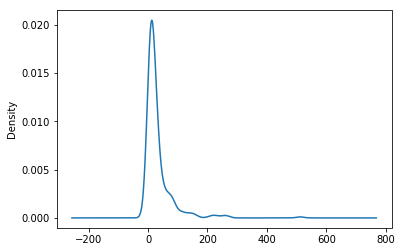

In [24]:
# 缺失值存在，分析Fare字段数据分布情况
df['Fare'].plot(kind='kde') # 密度图
df['Fare'].describe()

In [25]:
# 填充缺失值
df['Fare'].fillna(32.18, inplace=True)
df['Fare'].isnull().sum()

0

In [26]:
# 映射
def fn(x):
    if x < 8:
        return 0
    elif x < 32:
        return 1
    else:
        return 2
df['Fare'] = df['Fare'].map(fn)
df['Fare'].head()

0    0
1    2
2    0
3    2
4    1
Name: Fare, dtype: int64

Text(0, 0.5, 'num')

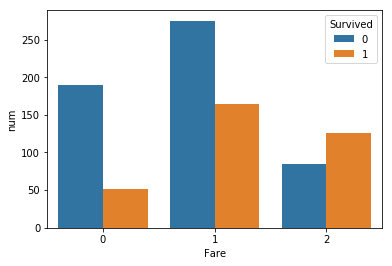

In [27]:
# 可视化处理
df1 = df.groupby(['Fare', 'Survived']).count()['Sex'].reset_index()
sns.barplot(x='Fare', y='Sex', hue='Survived', data=df1)
plt.ylabel('num')

## 2.7Cabin  
缺失太多，放弃

In [28]:
df['Cabin'].isnull().sum()

687

## 2.8 Embarked 上岸港口

In [29]:
df['Embarked'].isnull().sum()

2

In [30]:
df['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [31]:
# 缺失值数量少，而且S港口人数多，使用众数填充
df['Embarked'].fillna('S', inplace=True)

Text(0, 0.5, 'num')

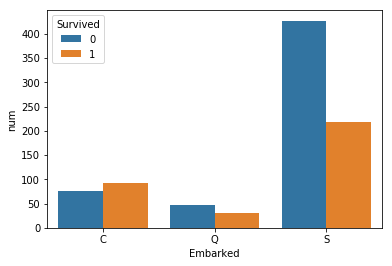

In [32]:
df1=df.groupby(['Embarked','Survived']).count()['Sex'].reset_index()
sns.barplot(x='Embarked', y='Sex', hue='Survived', data=df1)
plt.ylabel('num')

# 三、缺失值处理

1. 删除缺失值
2. 填充缺失值
3. 缺失值升维
4. 预测缺失值

## 3.1分析缺失值

In [33]:
df['Age'].isnull().sum()

177

缺失值数量大，直接删除损失的数据量多；填充缺失值，会导致数据出现噪音；缺失值升维不能很好用于预测是否幸存

预测缺失值  
1.先假设缺失值（Age）作为标签y，使用其他和Age相关的数据作为特征  
2.Age没有缺失的数据作为训练集，  Age有缺失作为测试集  
3.使用训练集数据训练模型， 使用测试集的特征得到预测结果   
4.填充到Age的缺失值中

## 3.2字段选择

In [34]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,family
0,0,3,Mr,male,22.0,1,0,A/5 21171,0,NaN,S,small
1,1,1,Mrs,female,38.0,1,0,PC 17599,2,C85,C,small
2,1,3,Miss,female,26.0,0,0,STON/O2. 3101282,0,NaN,S,single
3,1,1,Mrs,female,35.0,1,0,113803,2,C123,S,small
4,0,3,Mr,male,35.0,0,0,373450,1,NaN,S,single


In [35]:
# 新建一个df1，用于存储和age相关的数据信息
df1 = df[['Survived', 'Name', 'Age', 'Fare', 'family']]

## 3.3训练集和测试集切分

In [36]:
train = df1.loc[df1['Age'].notnull()] # Age不为空的数据，训练集
test = df1.loc[df1['Age'].isnull()]
# 分别切分x， y
x_train = train[['Survived', 'Name', 'Fare', 'family']]
y_train = train[['Age']]
x_test = test[['Survived', 'Name', 'Fare', 'family']]

In [37]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# 对特征进行标签化和独热编码化处理
le = LabelEncoder()
# 对每一个特征单独进行标签化处理
for i in x_train.columns: # 遍历特征的所有列名称
    le.fit(x_train[[i]]) # 只对训练集进行fit
    x_train[[i]] = le.transform(x_train[[i]])
    x_test[[i]] = le.transform(x_test[[i]])
x_train[:5]

,Survived,Name,Fare,family
0,0,3,0,2
1,1,4,2,2
2,1,2,0,1
3,1,4,2,2
4,0,3,1,1


In [38]:
# 独热处理
onehot = OneHotEncoder()
onehot.fit(x_train)
x_train = onehot.transform(x_train).toarray()
x_test = onehot.transform(x_test).toarray()
x_train[:5]

array([[1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1.],
       [0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1.],
       [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0.]])

## 3.4训练模型

In [39]:
# 创建线性回归模型
model = LinearRegression()
model.fit(x_train, y_train)
# 使用测试集的特征，来预测结果
y_ = model.predict(x_test)
y_[:5]

array([[34.1875],
       [32.8125],
       [35.5   ],
       [30.6875],
       [19.6875]])

## 3.5填充预测结果

In [40]:
# 最终缺失值填充到df中，用于后续是否幸存判断
df.loc[df['Age'].isnull(), 'Age'] = y_
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         891 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null int64
Cabin       204 non-null object
Embarked    891 non-null object
family      891 non-null object
dtypes: float64(1), int64(5), object(6)
memory usage: 83.6+ KB


## 3.6对当前的特征进行数据分析

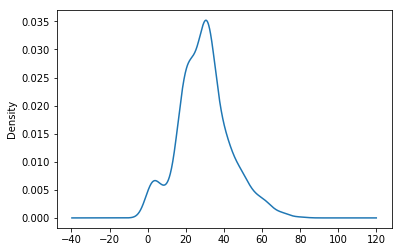

In [41]:
df['Age'].plot(kind='kde')

In [42]:
# 分段 0-14 15 - 50 51+
def fn(x):
    if x < 15:
        return 0
    elif x < 50:
        return 1
    else:
        return 2
df['Age'] = df['Age'].map(fn)

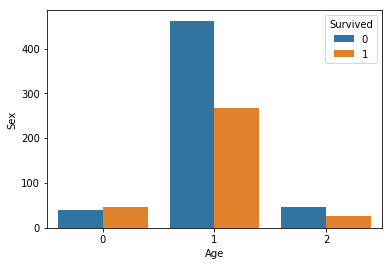

In [43]:
df1 = df.groupby(['Age', 'Survived']).count()['Sex'].reset_index()
sns.barplot(x='Age', y='Sex', hue='Survived', data=df1)

# 五、模型创建生存状态预测

In [44]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,family
0,0,3,Mr,male,1,1,0,A/5 21171,0,NaN,S,small
1,1,1,Mrs,female,1,1,0,PC 17599,2,C85,C,small
2,1,3,Miss,female,1,0,0,STON/O2. 3101282,0,NaN,S,single
3,1,1,Mrs,female,1,1,0,113803,2,C123,S,small
4,0,3,Mr,male,1,0,0,373450,1,NaN,S,single


In [45]:
# 删除SibSp，Parch， Ticket， Cabin
del df['SibSp']
del df['Parch']
del df['Ticket']
del df['Cabin']

In [46]:
# 切分x， y
x = df.iloc[:, 1:]
y = df.iloc[:, :1]
x.head()

,Pclass,Name,Sex,Age,Fare,Embarked,family
0,3,Mr,male,1,0,S,small
1,1,Mrs,female,1,2,C,small
2,3,Miss,female,1,0,S,single
3,1,Mrs,female,1,2,S,small
4,3,Mr,male,1,1,S,single


In [47]:
# 数据预处理  特征缩放、  标签化、独热编码
# 标签化  
# 每一列进行标签化处理
for i in x.columns:
    la = LabelEncoder()
    x[i] = la.fit_transform(x[i])
x.head()
# 独热编码
onehot = OneHotEncoder()
x = onehot.fit_transform(x).toarray()
x[:5]

array([[0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1.,
        0., 0., 0., 0., 1., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0.,
        0., 1., 1., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1.,
        0., 0., 0., 0., 1., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0.,
        0., 1., 0., 0., 1., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
        1., 0., 0., 0., 1., 0., 1., 0.]])

In [50]:
# 数据集切分
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=123)
# 利用网格搜索交叉验证 找出逻辑回归的最优参数
lr = LogisticRegression()
pg = {'penalty': ['l1', 'l2'], 'C': [1, 2, 5, 10]}
model = GridSearchCV(lr, pg, cv=5)
model.fit(x_train, y_train)
model.best_params_


{'C': 2, 'penalty': 'l1'}

In [51]:
# 使用最优参数创建模型，查找测试集的得分
lr = LogisticRegression(C=2, penalty='l1')
lr.fit(x_train, y_train)
lr.score(x_test, y_test)

0.8379888268156425

In [53]:
# 分类报告， roc
y_ = lr.predict(x_test)
print(classification_report(y_test, y_))

              precision    recall  f1-score   support

           0       0.86      0.89      0.88       114
           1       0.80      0.74      0.77        65

   micro avg       0.84      0.84      0.84       179
   macro avg       0.83      0.82      0.82       179
weighted avg       0.84      0.84      0.84       179



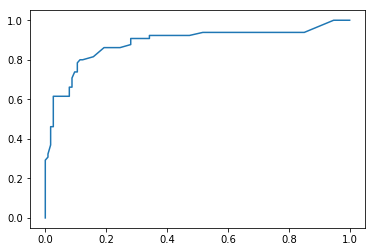

In [54]:
# roc 曲线
y_score = lr.predict_proba(x_test)[:, -1:] # 最后一列数据，模型的正类别概率
fpr, tpr, _ = roc_curve(y_test, y_score)
plt.plot(fpr, tpr)